In [1]:
from utils.Dataset import load_logging_data, create_lstm_dataset

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from typing import List, Optional

xs: List[Optional[str]] = []

In [2]:
train_dataset = load_logging_data(data_root_path='data/train')
val_dataset = load_logging_data(data_root_path='data/val')

Loading data...:   0%|          | 0/4 [00:00<?, ?it/s]

Loading data...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
angle_name_list = list(train_dataset.columns)[22:24] + list(train_dataset.columns)[26:28]
pressure_name_list = list(train_dataset.columns)[18:20] + list(train_dataset.columns)[24:26]

In [4]:
train_dataset['power'] = train_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] * train_dataset['caloutput_rotate_velocity CH=25']
train_dataset = train_dataset[['pressure_1_pressure_transmitter_1_drive1 CH=23']+angle_name_list+['caloutput_rotate_velocity CH=25', 'caloutput_drill_depth CH=26', 'power']]
train_dataset.describe()

for angle_name in angle_name_list:
    train_dataset[angle_name] = train_dataset[angle_name]/33

train_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] = train_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] / 256
train_dataset['caloutput_rotate_velocity CH=25'] = train_dataset['caloutput_rotate_velocity CH=25'] / 50
train_dataset['caloutput_drill_depth CH=26'] = train_dataset['caloutput_drill_depth CH=26'] / 31
train_dataset['power'] = train_dataset['power']/4100

In [5]:
val_dataset['power'] = val_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] * val_dataset['caloutput_rotate_velocity CH=25']
val_dataset = val_dataset[['pressure_1_pressure_transmitter_1_drive1 CH=23']+angle_name_list+['caloutput_rotate_velocity CH=25', 'caloutput_drill_depth CH=26', 'power']]
val_dataset.describe()

for angle_name in angle_name_list:
    val_dataset[angle_name] = val_dataset[angle_name]/33

val_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] = val_dataset['pressure_1_pressure_transmitter_1_drive1 CH=23'] / 256
val_dataset['caloutput_rotate_velocity CH=25'] = val_dataset['caloutput_rotate_velocity CH=25'] / 50
val_dataset['caloutput_drill_depth CH=26'] = val_dataset['caloutput_drill_depth CH=26'] / 31
val_dataset['power'] = val_dataset['power']/4100

In [6]:
train_extract_dataset = train_dataset[['pressure_1_pressure_transmitter_1_drive1 CH=23']+angle_name_list+['caloutput_rotate_velocity CH=25', 'caloutput_drill_depth CH=26', 'power']]
val_extract_dataset = val_dataset[['pressure_1_pressure_transmitter_1_drive1 CH=23']+angle_name_list+['caloutput_rotate_velocity CH=25', 'caloutput_drill_depth CH=26', 'power']]

In [7]:
seq_len = 30
pred_distance = 10


train_feature, train_target = create_lstm_dataset(train_extract_dataset.values, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=7)
val_feature, val_target = create_lstm_dataset(val_extract_dataset.values, seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=7)

In [8]:
class SimpleTransformerRegression(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super().__init__()
        self.model_dim = model_dim
        # 입력 차원을 model_dim으로 맞춰주기 위한 선형 변환
        self.input_linear = nn.Linear(input_dim, model_dim)

        # TransformerEncoderLayer 정의
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True  # (batch_size, sequence_length, features) 형태로 입력 받음
        )
        # 여러 개의 EncoderLayer를 쌓아 TransformerEncoder 생성
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 최종 예측을 위한 회귀 헤드 (선형 레이어)
        # 트랜스포머 인코더의 출력은 (batch_size, seq_len, model_dim) 형태
        # 우리는 이 시퀀스 전체 정보를 압축하여 하나의 값을 예측해야 합니다.
        # 여기서는 마지막 시점의 출력을 사용하거나, 모든 시점의 출력을 평균낼 수 있습니다.
        # 여기서는 단순히 마지막 시점의 출력을 사용하여 회귀합니다.
        self.output_linear = nn.Linear(model_dim, 1)

    def forward(self, src):
        # src: (batch_size, seq_len, input_dim)

        # input_dim을 model_dim으로 변환
        src = self.input_linear(src)  # (batch_size, seq_len, model_dim)

        # TransformerEncoder에 입력 (batch_first=True 설정)
        transformer_output = self.transformer_encoder(src)  # (batch_size, seq_len, model_dim)

        # 마지막 시점의 출력만 사용 (가장 최근 정보를 활용)
        # 또는 전체 시퀀스 출력을 평균내거나, Max/Mean Pooling을 적용할 수도 있습니다.
        regression_input = transformer_output[:, -1, :]  # (batch_size, model_dim)

        # 회귀 헤드를 통해 최종 값 예측
        output = self.output_linear(regression_input)  # (batch_size, 1)
        return output

In [9]:
# 모델 파라미터 설정
INPUT_DIM = train_feature.shape[2]  # 각 시점 데이터의 차원 (여기서는 사인 값 하나이므로 1)
MODEL_DIM = 256  # 트랜스포머 내부 모델 차원
NUM_HEADS = 4  # 어텐션 헤드 수
NUM_LAYERS = 3  # 인코더 레이어 수
DROPOUT = 0.1

model = SimpleTransformerRegression(INPUT_DIM, MODEL_DIM, NUM_HEADS, NUM_LAYERS, DROPOUT)
print(model)


모델 구조:
SimpleTransformerRegression(
  (input_linear): Linear(in_features=8, out_features=256, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_linear): Linear(in_features=256, out_features=1, bias=True)
)


In [10]:
X_train = torch.FloatTensor(train_feature)
y_train = torch.FloatTensor(train_target).unsqueeze(1)
X_test = torch.FloatTensor(val_feature)
y_test = torch.FloatTensor(val_target).unsqueeze(1)

In [11]:
criterion = nn.MSELoss()  # 평균 제곱 오차 (회귀 문제에 적합)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

NUM_EPOCHS = 100

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# --- 4. 모델 학습 ---
print("\n모델 학습 시작...")
train_losses = []
for epoch in range(NUM_EPOCHS):
    model.train()  # 학습 모드
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}')

print("모델 학습 완료.")


모델 학습 시작...


C:\Users\jinbeom\miniconda3\envs\pytorch_240_gpu_python311\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/100], Loss: 0.2896
Epoch [2/100], Loss: 48.5714
Epoch [3/100], Loss: 12.9144
Epoch [4/100], Loss: 0.2425
Epoch [5/100], Loss: 2.6398
Epoch [6/100], Loss: 3.0277
Epoch [7/100], Loss: 1.3719
Epoch [8/100], Loss: 0.1204
Epoch [9/100], Loss: 0.3600
Epoch [10/100], Loss: 0.7284
Epoch [11/100], Loss: 0.4748
Epoch [12/100], Loss: 0.1426
Epoch [13/100], Loss: 0.0241
Epoch [14/100], Loss: 0.0828
Epoch [15/100], Loss: 0.1786
Epoch [16/100], Loss: 0.2174
Epoch [17/100], Loss: 0.1917
Epoch [18/100], Loss: 0.1265
Epoch [19/100], Loss: 0.0619
Epoch [20/100], Loss: 0.0273
Epoch [21/100], Loss: 0.0300
Epoch [22/100], Loss: 0.0561
Epoch [23/100], Loss: 0.0813
Epoch [24/100], Loss: 0.0900
Epoch [25/100], Loss: 0.0800
Epoch [26/100], Loss: 0.0608
Epoch [27/100], Loss: 0.0404
Epoch [28/100], Loss: 0.0271
Epoch [29/100], Loss: 0.0242
Epoch [30/100], Loss: 0.0294
Epoch [31/100], Loss: 0.0380
Epoch [32/100], Loss: 0.0447
Epoch [33/100], Loss: 0.0463
Epoch [34/100], Loss: 0.0434
Epoch [35/100], Loss:

KeyboardInterrupt: 

In [13]:
# --- 5. 모델 평가 및 예측 ---
model.eval()
# 평가 모드
with torch.no_grad():
    train_predict = np.squeeze(model(X_train).cpu().numpy())
    test_predict = np.squeeze(model(X_test).cpu().numpy())

<Axes: >

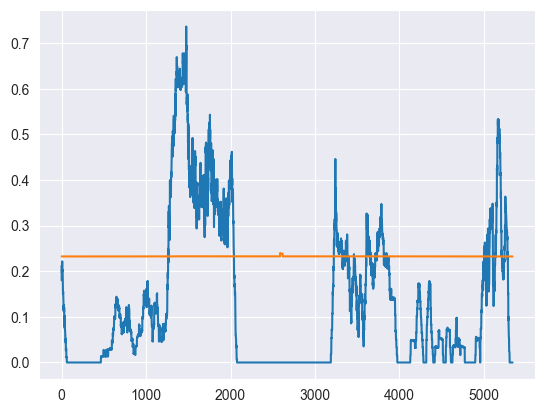

In [16]:
sns.lineplot(val_target)
sns.lineplot(test_predict)

(0.0, 1.0)

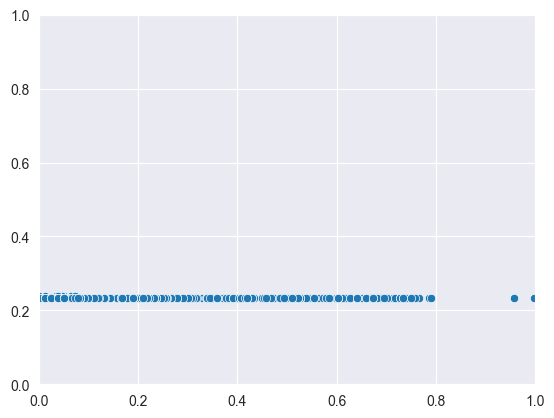

In [14]:
sns.scatterplot(x=train_target, y=train_predict)

plt.xlim(0, 1)
plt.ylim(0, 1)

<Axes: >

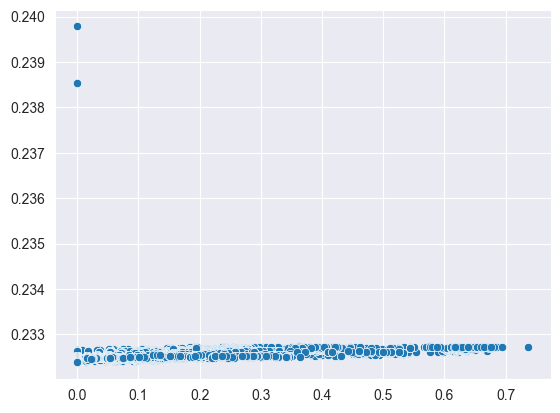

In [15]:
sns.scatterplot(x=val_target, y=test_predict)

In [ ]:
# 예측 결과 시각화
plt.figure(figsize=(15, 6))

plt.plot(np.arange(NUM_SAMPLES), y_np, label='Original Data')
plt.plot(np.arange(train_size, NUM_SAMPLES), test_predict, label='Predicted (Test Set)', linestyle='--')
plt.plot(np.arange(train_size), train_predict, label='Predicted (Train Set)', linestyle=':')

plt.title('Sine Wave Prediction with Transformer Regression')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# 학습 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 테스트 오차 계산
test_loss = criterion(torch.tensor(test_predict).to(device), y_test).item()
print(f"\nTest Loss (MSE): {test_loss:.4f}")